# Replication - Resource comparision (Runtime only)

Here we provide a notebook that showcases how to replicate the resource results. (This is not exact as hardware etc. will be differnt).
We also cannot provide the memory footprint as we cannot measure it for the R scripts. 
For simplicity we also do not provide the Probcox - Hard drive version here.

The notebook indicates how to replicate the results in:
- /out/resources/*

The main script can be found at: 
- /scripts/resources/*


In [ ]:
# google colab specific - installing probcox
!pip3 install probcox
!pip3 install lifelines

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R 
install.packages('survival')
install.packages('glmnet')

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/survival_3.2-11.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 6274168 bytes (6.0 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[w

In [ ]:
%%R 
library(survival)
library(glmnet)

R[write to console]: Loading required package: Matrix

R[write to console]: Loaded glmnet 4.1-1



In [ ]:
# Modules
# =======================================================================================================================
import os
import sys
import shutil
import subprocess
import tqdm

import numpy as np
import pandas as pd
from lifelines import CoxTimeVaryingFitter

import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist

from pyro.infer import SVI, Trace_ELBO

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import probcox as pcox

dtype = torch.FloatTensor

np.random.seed(9044)
torch.manual_seed(8734)




In [ ]:
# Plot Settings
# =======================================================================================================================

plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 10
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False


In [ ]:
# ProbCox settings
# =======================================================================================================================
batchsize = 256

def predictor(data):
    theta =  pyro.sample("theta", dist.StudentT(1, loc=0, scale=0.001).expand([data[1].shape[1], 1])).type(dtype)
    pred = torch.mm(data[1], theta)
    return(pred)

In [ ]:
# Simulation - 10 Significant covariates
# =======================================================================================================================
def simulate(I, P):
  P_binary = int(P/2)
  P_continuous = int(P/2)
  theta = np.random.normal(0, 0.5, (10, 1))
  theta = np.concatenate((theta[:5], np.zeros((int(P/2-5), 1)), theta[5:], np.zeros((int(P/2-5), 1))))
  scale = 2  # Scaling factor for Baseline Hazard

  # Class for simulation
  TVC = pcox.TVC(theta=theta, P_binary=P_binary, P_continuous=P_continuous, dtype=dtype)

  # Sample baseline hazard - scale is set to define censorship/events
  TVC.make_lambda0(scale=scale)

  # Sample Data 
  surv = torch.zeros((0, 3))
  X = torch.zeros((0, P))
  for __ in tqdm.tqdm(range(I)):
      a, b = TVC.sample()
      surv = torch.cat((surv, a))
      X = torch.cat((X, b))
  return(surv, X, theta)

In [ ]:
# ProbCox
# =======================================================================================================================
def run_probcox(surv, X, sampling_proportion, predictor=predictor):
  eta=1
  run = True
  while run:
      run = False
      pyro.clear_param_store()
      m = pcox.PCox(sampling_proportion=sampling_proportion, predictor=predictor)
      m.initialize(eta=eta, rank=25)
      loss=[0]
      for ii in tqdm.tqdm(range((25000))):
          # random sub-sampling
          idx = np.random.choice(range(surv.shape[0]), batchsize, replace=False)
          data=[surv[idx], X[idx]]
          loss.append(m.infer(data=data))
          # divergence check
          if loss[-1] != loss[-1]:
              eta = eta * 0.1
              run=True
              break   
  g = m.return_guide()
  out = g.quantiles([0.025, 0.5, 0.975])
  return(out)    

In [ ]:
# Simulate Data
# =======================================================================================================================
pyro.clear_param_store()
np.random.seed(9044)
torch.manual_seed(8734)
surv, X, theta = simulate(I=16000, P=3200)
print(surv.shape[0])
# sampling proportion
total_obs = surv.shape[0]
total_events = torch.sum(surv[:, -1] == 1).numpy().tolist()
sampling_proportion=[total_obs, batchsize, total_events, None]
# Make High-dimensional Data
# R dataset 
rd = pd.DataFrame(np.concatenate((surv.detach().numpy(), X.detach().numpy()), axis=1))
rd.columns = ['V' + str(ii) for ii in range(1, rd.shape[1]+1)]


100%|██████████| 16000/16000 [55:14<00:00,  4.83it/s]


119071


In [ ]:
%%time
out = run_probcox(surv=surv, X=X, sampling_proportion=sampling_proportion)


100%|██████████| 25000/25000 [13:35<00:00, 30.67it/s]

CPU times: user 11min 27s, sys: 2min 7s, total: 13min 35s
Wall time: 13min 35s


In [ ]:
'''
%%time
%%R -i rd -o r_coef
set.seed(7)
Surv(rd$V1, rd$V2, rd$V3)
m = coxph(Surv(V1, V2, V3)~., data=rd)
r_coef <- as.matrix(unname(coef(m)))
'''
# More then an hour to run

'\n%%time\n%%R -i rd -o r_coef\nset.seed(7)\nSurv(rd$V1, rd$V2, rd$V3)\nm = coxph(Surv(V1, V2, V3)~., data=rd)\nr_coef <- as.matrix(unname(coef(m)))\n'

In [ ]:
'''
%%time
%%R -i rd -o r_coef
set.seed(13)
yss = Surv(rd$V1, rd$V2, rd$V3)
m <- glmnet(as.matrix(rd[, 4:3203]), yss, family ="cox")
r_coef <- as.matrix(unname(coef(m)))
'''
# crashes for memory

'\n%%time\n%%R -i rd -o r_coef\nset.seed(13)\nyss = Surv(rd$V1, rd$V2, rd$V3)\nm <- glmnet(as.matrix(rd[, 4:3203]), yss, family ="cox")\nr_coef <- as.matrix(unname(coef(m)))\n'

In [ ]:
%%time
ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(rd, event_col="V3", start_col="V1", stop_col="V2", show_progress=False)


In [ ]:
# Simulate Data
# =======================================================================================================================
pyro.clear_param_store()
np.random.seed(9044)
torch.manual_seed(8734)
surv, X, theta = simulate(I=8000, P=1600)
print(surv.shape[0])
# sampling proportion
total_obs = surv.shape[0]
total_events = torch.sum(surv[:, -1] == 1).numpy().tolist()
sampling_proportion=[total_obs, batchsize, total_events, None]
# Make High-dimensional Data
# R dataset 
rd = pd.DataFrame(np.concatenate((surv.detach().numpy(), X.detach().numpy()), axis=1))
rd.columns = ['V' + str(ii) for ii in range(1, rd.shape[1]+1)]

100%|██████████| 8000/8000 [07:56<00:00, 16.78it/s]


58842


In [ ]:
%%time
out = run_probcox(surv=surv, X=X, sampling_proportion=sampling_proportion)

100%|██████████| 25000/25000 [07:12<00:00, 57.82it/s]

CPU times: user 6min 16s, sys: 56.6 s, total: 7min 13s
Wall time: 7min 12s


In [ ]:
%%time
%%R -i rd -o r_coef
set.seed(7)
Surv(rd$V1, rd$V2, rd$V3)
m = coxph(Surv(V1, V2, V3)~., data=rd)
r_coef <- as.matrix(unname(coef(m)))

CPU times: user 1h 3min 34s, sys: 5.04 s, total: 1h 3min 39s
Wall time: 1h 3min 20s


In [ ]:
%%time
%%R -i rd -o r_coef
set.seed(13)
yss = Surv(rd$V1, rd$V2, rd$V3)
m <- glmnet(as.matrix(rd[, 4:1603]), yss, family ="cox")
r_coef <- as.matrix(unname(coef(m)))

CPU times: user 16min 47s, sys: 57.8 s, total: 17min 44s
Wall time: 16min 17s


In [ ]:
%%time
ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(rd, event_col="V3", start_col="V1", stop_col="V2", show_progress=False)


In [ ]:
# Simulate Data
# =======================================================================================================================
pyro.clear_param_store()
np.random.seed(9044)
torch.manual_seed(8734)
surv, X, theta = simulate(I=4000, P=800)
print(surv.shape[0])
# sampling proportion
total_obs = surv.shape[0]
total_events = torch.sum(surv[:, -1] == 1).numpy().tolist()
sampling_proportion=[total_obs, batchsize, total_events, None]
# Make High-dimensional Data
# R dataset 
rd = pd.DataFrame(np.concatenate((surv.detach().numpy(), X.detach().numpy()), axis=1))
rd.columns = ['V' + str(ii) for ii in range(1, rd.shape[1]+1)]

100%|██████████| 4000/4000 [01:46<00:00, 37.71it/s]

29628


In [ ]:
%%time
out = run_probcox(surv=surv, X=X, sampling_proportion=sampling_proportion)

100%|██████████| 25000/25000 [03:47<00:00, 109.92it/s]

CPU times: user 3min 45s, sys: 2.93 s, total: 3min 48s
Wall time: 3min 47s


In [ ]:
%%time
%%R -i rd -o r_coef
set.seed(7)
Surv(rd$V1, rd$V2, rd$V3)
m = coxph(Surv(V1, V2, V3)~., data=rd)
r_coef <- as.matrix(unname(coef(m)))

CPU times: user 4min 55s, sys: 595 ms, total: 4min 56s
Wall time: 4min 55s


In [ ]:
%%time
%%R -i rd -o r_coef
set.seed(13)
yss = Surv(rd$V1, rd$V2, rd$V3)
m <- glmnet(as.matrix(rd[, 4:803]), yss, family ="cox")
r_coef <- as.matrix(unname(coef(m)))

CPU times: user 4min 21s, sys: 43.5 s, total: 5min 4s
Wall time: 4min 9s


In [ ]:
%%time
ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(rd, event_col="V3", start_col="V1", stop_col="V2", show_progress=False)


In [ ]:
# Simulate Data
# =======================================================================================================================
pyro.clear_param_store()
np.random.seed(9044)
torch.manual_seed(8734)
surv, X, theta = simulate(I=2000, P=400)
print(surv.shape[0])
# sampling proportion
total_obs = surv.shape[0]
total_events = torch.sum(surv[:, -1] == 1).numpy().tolist()
sampling_proportion=[total_obs, batchsize, total_events, None]
# Make High-dimensional Data
# R dataset 
rd = pd.DataFrame(np.concatenate((surv.detach().numpy(), X.detach().numpy()), axis=1))
rd.columns = ['V' + str(ii) for ii in range(1, rd.shape[1]+1)]

100%|██████████| 2000/2000 [00:22<00:00, 88.78it/s]

14937


In [ ]:
%%time
out = run_probcox(surv=surv, X=X, sampling_proportion=sampling_proportion)

100%|██████████| 25000/25000 [02:33<00:00, 162.88it/s]

CPU times: user 2min 32s, sys: 1.83 s, total: 2min 34s
Wall time: 2min 33s


In [ ]:
%%time
%%R -i rd -o r_coef
set.seed(7)
Surv(rd$V1, rd$V2, rd$V3)
m = coxph(Surv(V1, V2, V3)~., data=rd)
r_coef <- as.matrix(unname(coef(m)))

CPU times: user 46.5 s, sys: 191 ms, total: 46.7 s
Wall time: 46.5 s


In [ ]:
%%time
%%R -i rd -o r_coef
set.seed(13)
yss = Surv(rd$V1, rd$V2, rd$V3)
m <- glmnet(as.matrix(rd[, 4:403]), yss, family ="cox")
r_coef <- as.matrix(unname(coef(m)))

CPU times: user 2min 20s, sys: 1min 2s, total: 3min 22s
Wall time: 2min 8s


In [ ]:
%%time
ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(rd, event_col="V3", start_col="V1", stop_col="V2", show_progress=False)


In [ ]:
# Simulate Data
# =======================================================================================================================
pyro.clear_param_store()
np.random.seed(9044)
torch.manual_seed(8734)
surv, X, theta = simulate(I=1000, P=200)
print(surv.shape[0])
# sampling proportion
total_obs = surv.shape[0]
total_events = torch.sum(surv[:, -1] == 1).numpy().tolist()
sampling_proportion=[total_obs, batchsize, total_events, None]
# Make High-dimensional Data
# R dataset 
rd = pd.DataFrame(np.concatenate((surv.detach().numpy(), X.detach().numpy()), axis=1))
rd.columns = ['V' + str(ii) for ii in range(1, rd.shape[1]+1)]

100%|██████████| 1000/1000 [00:05<00:00, 189.02it/s]

7248


In [ ]:
%%time
out = run_probcox(surv=surv, X=X, sampling_proportion=sampling_proportion)

100%|██████████| 25000/25000 [01:53<00:00, 220.25it/s]

CPU times: user 1min 52s, sys: 1.24 s, total: 1min 54s
Wall time: 1min 53s


In [ ]:
%%time
%%R -i rd -o r_coef
set.seed(7)
Surv(rd$V1, rd$V2, rd$V3)
m = coxph(Surv(V1, V2, V3)~., data=rd)
r_coef <- as.matrix(unname(coef(m)))

CPU times: user 7.97 s, sys: 55.6 ms, total: 8.02 s
Wall time: 7.99 s


In [ ]:
%%time
%%R -i rd -o r_coef
set.seed(13)
yss = Surv(rd$V1, rd$V2, rd$V3)
m <- glmnet(as.matrix(rd[, 4:203]), yss, family ="cox")
r_coef <- as.matrix(unname(coef(m)))

CPU times: user 48.4 s, sys: 32 s, total: 1min 20s
Wall time: 43.1 s


In [ ]:
%%time
ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(rd, event_col="V3", start_col="V1", stop_col="V2", show_progress=False)


## Report results:

In [ ]:
I =  ['I:1000, P:200', 'I:2000, P:400', 'I:4000, P:800', 'I:8000, P:1600', 'I:16000, P:3200']
probcox = [113, 153, 227, 432, 815]
rsurvival = [8, 47, 295, 3800]
rglmnet = [43, 128, 249, 977]

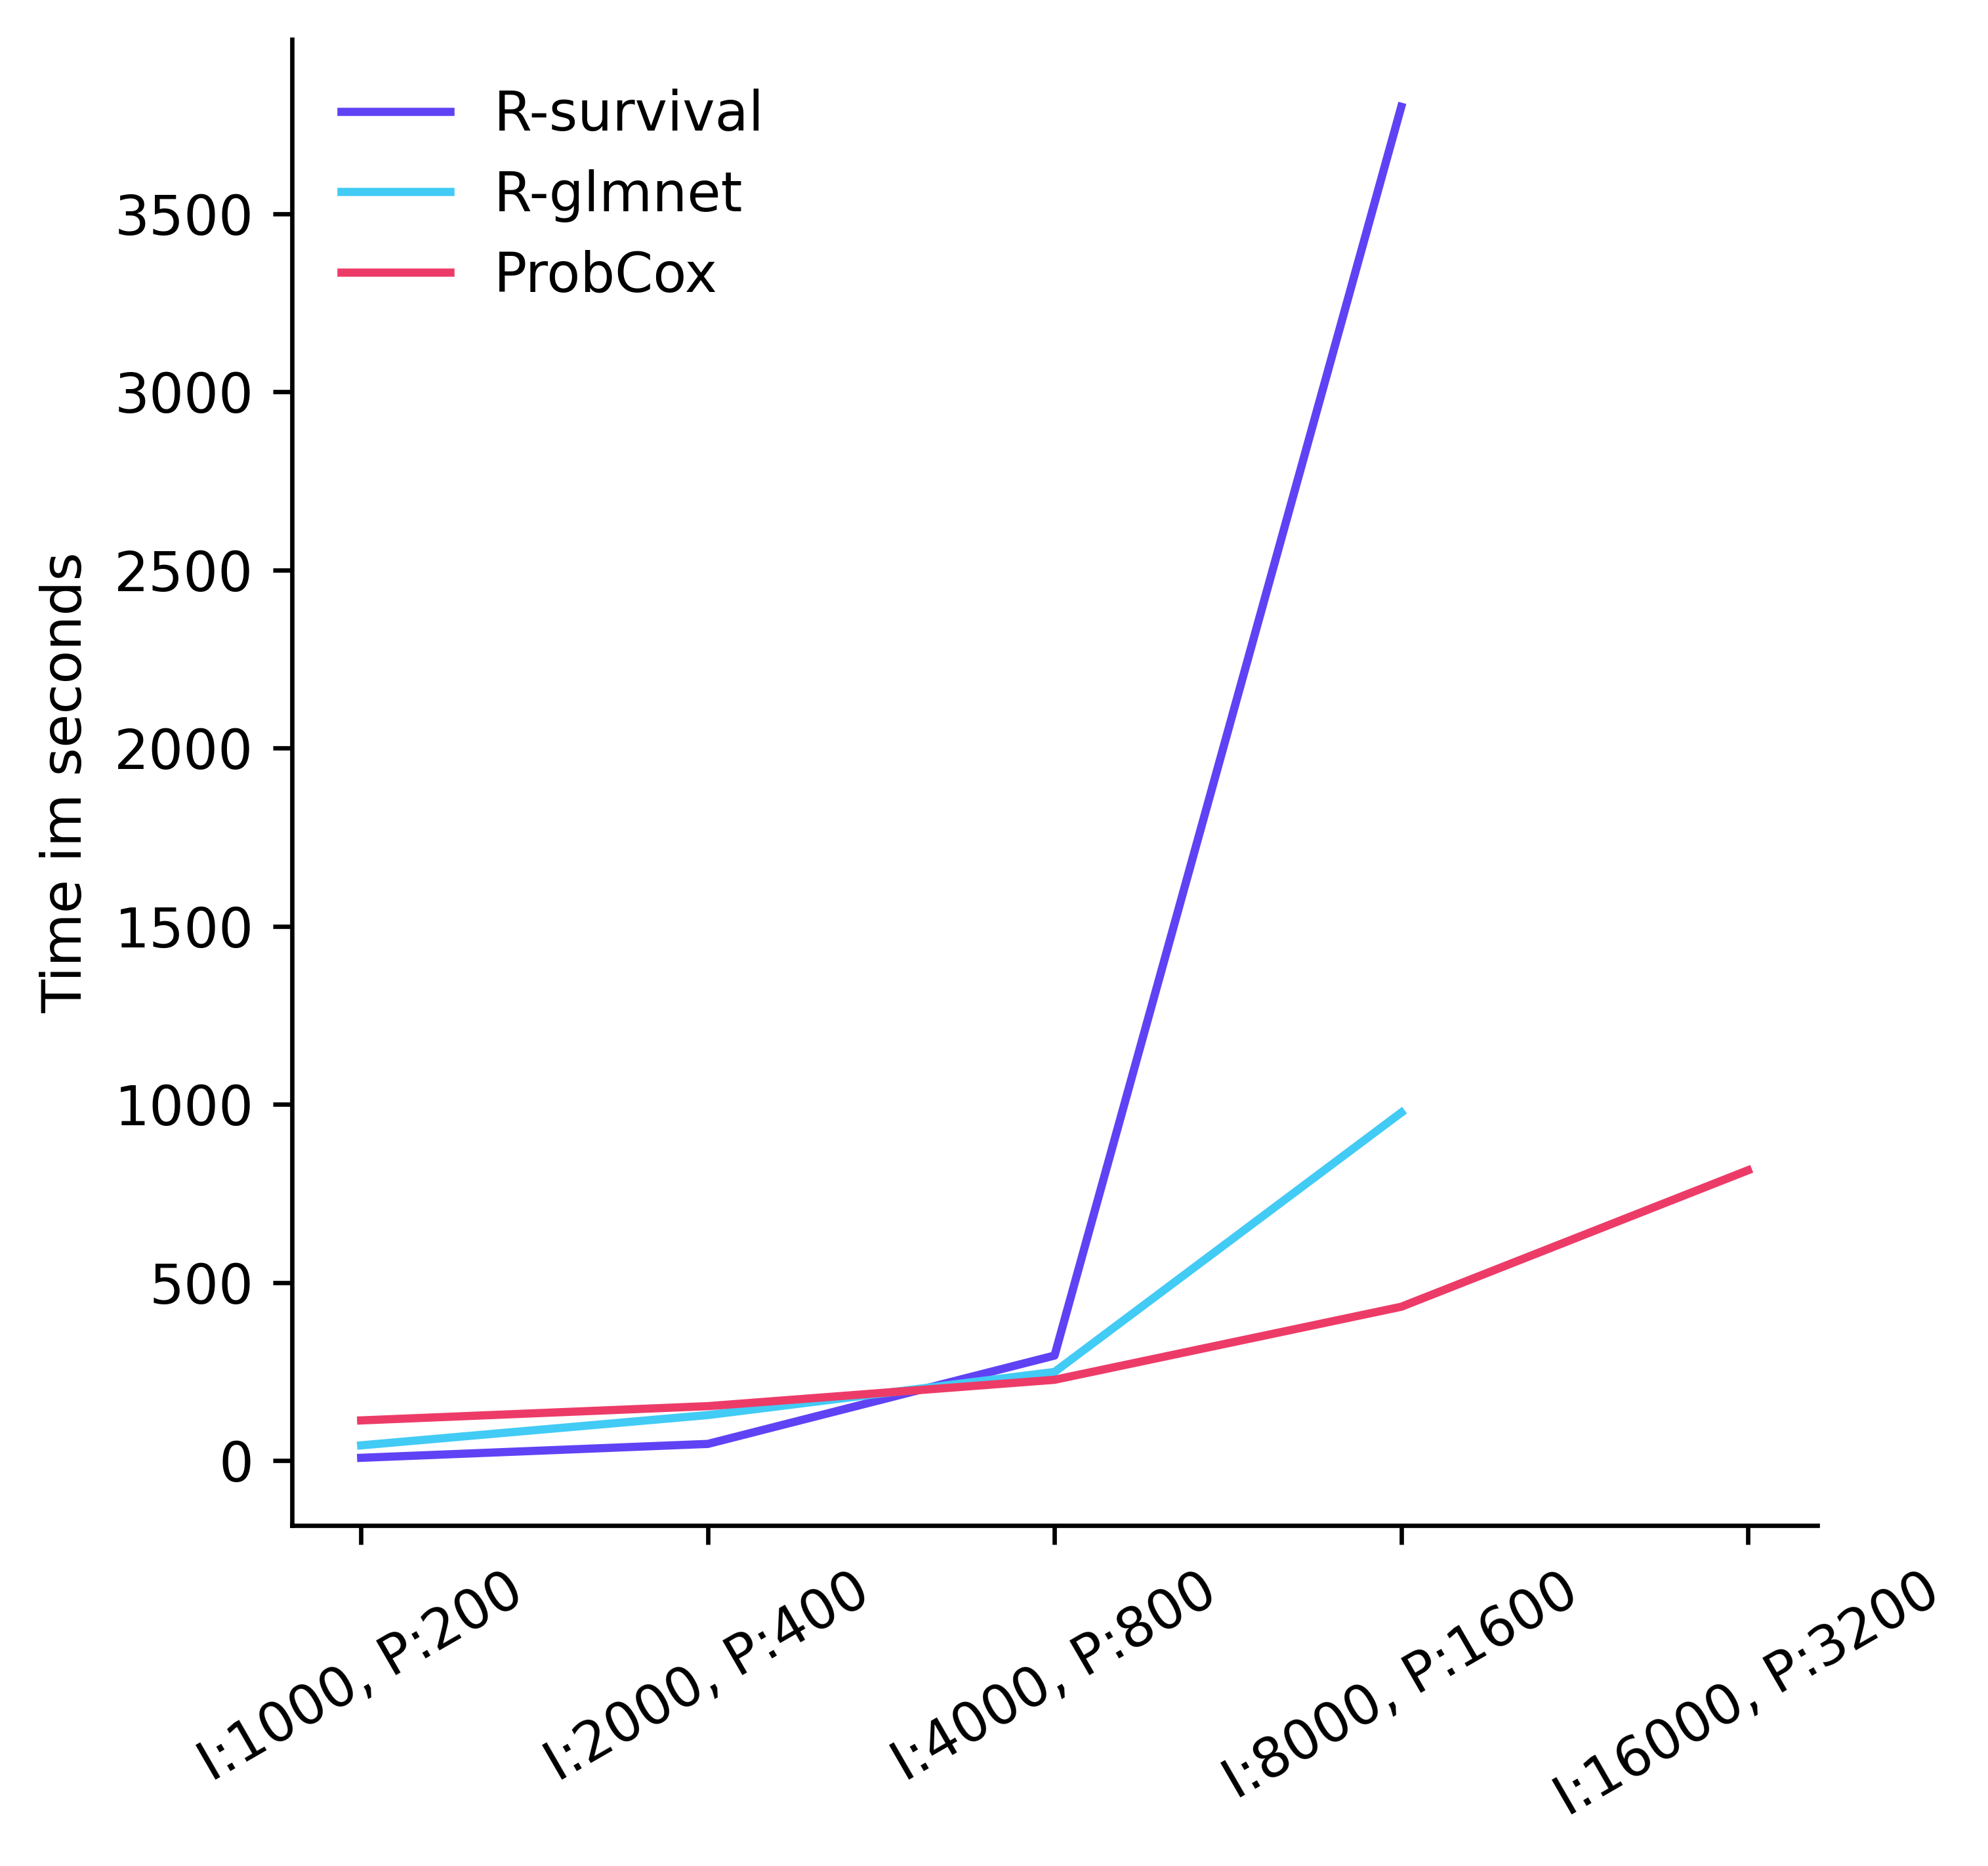

In [ ]:
plt.figure(figsize=(5, 5), dpi=600)
plt.plot(np.arange(4), rsurvival, label='R-survival', color='#6042f5')
plt.plot(np.arange(4), rglmnet, label='R-glmnet', color='#42cbf5')
plt.plot(np.arange(5), probcox, label='ProbCox', color='#ed3b68')
plt.xticks(np.arange(5), labels=I, rotation = 30)
plt.ylabel('Time im seconds')
plt.legend(frameon=False)
plt.show()
plt.close()

# Compute Specifications

In [ ]:
from psutil import *

In [ ]:
print(cpu_count())
print(cpu_stats())

2
scpustats(ctx_switches=909005, interrupts=497243, soft_interrupts=463222, syscalls=0)


In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	:

In [ ]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   39G   70G  36% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.9G     0  5.9G   0% /dev/shm
tmpfs           6.4G   24K  6.4G   1% /var/colab
/dev/sda1       114G   41G   74G  36% /etc/hosts
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G  1.5G   14G  10% /content/drive


In [ ]:
virtual_memory()

svmem(total=13624659968, available=12569526272, percent=7.7, used=817012736, free=10235473920, active=1284788224, inactive=1846288384, buffers=92569600, cached=2479603712, shared=1175552, slab=202276864)